In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# MNISTデータセットのロード
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))

# データサンプリング
sample_size = x_train.shape[0]
x_train = x_train[:sample_size]
y_train = y_train[:sample_size]

# VAEのモデル定義
latent_dim = 2  # 潜在空間の次元数

def build_vae(latent_dim):
    # エンコーダー
    encoder_inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
    x = layers.MaxPooling2D(padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    # デコーダー
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

    vae_outputs = decoder(encoder(encoder_inputs)[2])
    vae = models.Model(encoder_inputs, vae_outputs, name="vae")

    return vae, encoder, decoder

vae, encoder, decoder = build_vae(latent_dim)
vae.compile(optimizer='adam', loss='binary_crossentropy')

ファイル数: 405198


2024-08-19 11:33:45.491267: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(32, 128, 128, 3)
トレーニングデータのバッチ数: 12663
テストデータのバッチ数: 0
Epoch 1/10


ValueError: as_list() is not defined on an unknown TensorShape.

In [12]:
# VAEの訓練
vae.fit(x_train, x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - loss: 0.3112
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - loss: 0.2146
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - loss: 0.2032
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - loss: 0.1981
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - loss: 0.1950
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - loss: 0.1931
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - loss: 0.1918
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - loss: 0.1907
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - loss: 0.1892
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.1889


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


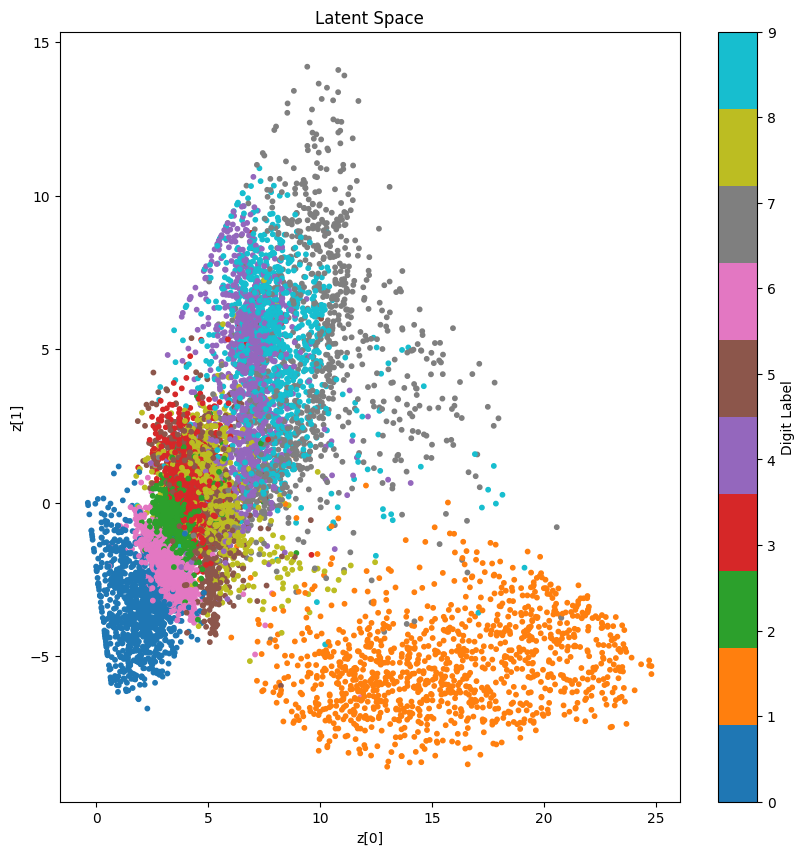

In [13]:
# 潜在空間のプロット
def plot_latent_space(encoder, x_test, y_test, figsize=(10, 10)):
    z_mean, _, _ = encoder.predict(x_test, batch_size=128)
    plt.figure(figsize=figsize)
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='tab10', s=10)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space")
    plt.colorbar(scatter, label='Digit Label')
    plt.show()

plot_latent_space(encoder, x_test[:sample_size], y_test[:sample_size])

In [14]:
def generate_latent_space_images(decoder, grid_size=10, min_val=-4.0, max_val=4.0):
    # 潜在空間のグリッドを作成
    grid_x = np.linspace(min_val, max_val, grid_size)
    grid_y = np.linspace(min_val, max_val, grid_size)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    
    # グリッドの座標をフラット化
    latent_samples = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
    
    # デコーダーを使って画像を生成
    generated_images = decoder.predict(latent_samples)
    
    # 画像サイズの取得
    image_height, image_width = generated_images.shape[1:3]
    
    # グリッド上に画像を並べる
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * image_width / 100, grid_size * image_height / 100), dpi=100)
    
    # 画像の間隔を0にする
    plt.subplots_adjust(wspace=0, hspace=0)
    
    axs = axs.flatten()
    for img, ax in zip(generated_images, axs):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    
    # グリッドの背景色を透明にする
    fig.patch.set_visible(False)
    plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


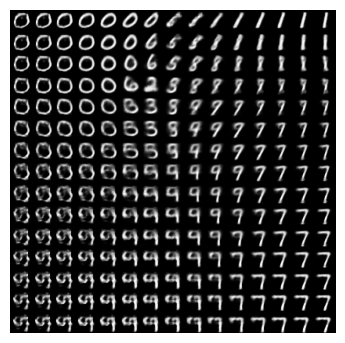

In [64]:
# 潜在空間の最大値と最小値に基づいて画像を生成
min_val = -5
max_val = 15
generate_latent_space_images(decoder, grid_size=15, min_val=min_val, max_val=max_val)

In [16]:
# 潜在空間の最大値を計算する関数
def calculate_latent_space_max(decoder, num_samples=10000):
    # 潜在空間からサンプルを生成
    latent_samples = np.random.normal(size=(num_samples, latent_dim))
    
    # デコーダーを使って画像を生成
    generated_images = decoder.predict(latent_samples)
    
    # 潜在空間の最大値を計算
    max_latent_values = np.max(latent_samples, axis=0)
    min_latent_values = np.min(latent_samples, axis=0)
    
    return max_latent_values, min_latent_values
# 潜在空間の最大値を計算
max_latent, min_latent = calculate_latent_space_max(decoder)
print("Latent Space Max Values:", max_latent)
print("Latent Space Min Values:", min_latent)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Latent Space Max Values: [3.65028108 3.47270695]
Latent Space Min Values: [-4.16358887 -4.20905316]


In [50]:
# 潜在空間の最大値を計算する関数
def calculate_latent_space_max(decoder, num_samples=10000):
    # 潜在空間からサンプルを生成
    latent_samples = np.random.normal(size=(num_samples, latent_dim))
    
    # デコーダーを使って画像を生成
    generated_images = decoder.predict(latent_samples)
    
    # 潜在空間の最大値を計算
    max_latent_values = np.max(latent_samples, axis=0)
    min_latent_values = np.min(latent_samples, axis=0)
    
    return max_latent_values, min_latent_values

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Latent Space Max Values: [3.95142824 3.81425007]
Latent Space Min Values: [-3.43049207 -3.51875862]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


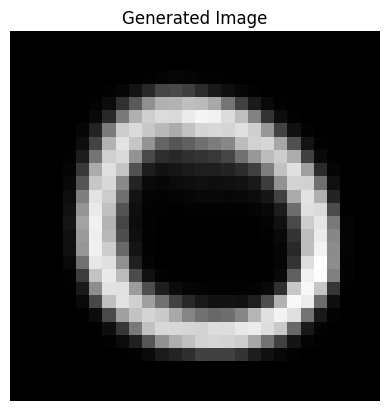

In [59]:
# 潜在空間の最大値を計算
max_latent, min_latent = calculate_latent_space_max(decoder)
print("Latent Space Max Values:", max_latent)
print("Latent Space Min Values:", min_latent)

x = 0
y = -0
# 任意の座標を指定
input_coordinates = np.array([x, y])  # 例として2次元の座標を指定

# デコーダーを使用して画像を生成
generated_image = decoder.predict(np.expand_dims(input_coordinates, axis=0))

# 生成された画像を表示
plt.imshow(generated_image[0], cmap='gray')
plt.title("Generated Image")
plt.axis('off')
plt.show()